In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets,transforms,models
from torch import nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
import importlib
import fc_loader
import helper

## Understanding shapes of given data

In [3]:
data_folder = '../data/flower_data/'

transform_test = transforms.Compose([transforms.ToTensor()])

traindataset=datasets.ImageFolder(root= data_folder + 'train',transform=transform_test)
validdataset=datasets.ImageFolder(root= data_folder + 'valid',transform=transform_test)

trainloader=torch.utils.data.DataLoader(traindataset,batch_size=1,shuffle=True)
validloader=torch.utils.data.DataLoader(validdataset,batch_size=1,shuffle=True)

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
labels_classes={labels:classes for classes,labels in 
                traindataset.class_to_idx.items()}
classes_labels = traindataset.class_to_idx

In [6]:
diter=iter(trainloader)
images,labels=next(diter)

In [7]:
steps=[]
labels_check=[]
for images,labels in trainloader:
    steps.append(images.shape)
    labels_check.append(labels)

In [8]:
height=list(map(lambda x:x[2],steps))
width=list(map(lambda x:x[-1],steps))

Minimum height is 500 and Max height is 1168


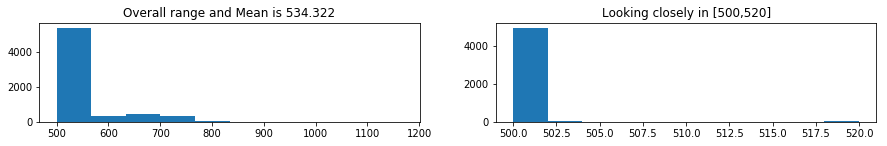

In [9]:
fig1=plt.figure(figsize=(15,4),num=2)
fig1.add_subplot(2,2,1)
plt.hist(height);
plt.title(r'Overall range and Mean is {:.3f}'.format(np.mean(height)))
fig1.add_subplot(2,2,2)
plt.hist(height,range=(500,520));
plt.title(r'Looking closely in [500,520]'.format());

print(r'Minimum height is {} and Max height is {}'.format(min(height),max(height)))

Minimum width is 500 and Max width is 1024


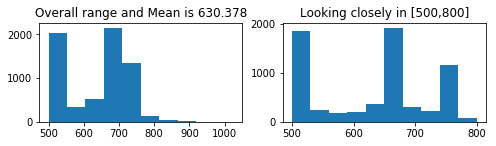

In [10]:
fig2=plt.figure(figsize=(8,4),num=2)
fig2.add_subplot(2,2,3)
plt.hist(width);
plt.title(r'Overall range and Mean is {:.3f}'.format(np.mean(width)));
fig2.add_subplot(2,2,4)
plt.hist(width,range=(500,800));
plt.title(r'Looking closely in [500,800]'.format());

print(r'Minimum width is {} and Max width is {}'.format(min(width),
                                                          max(width)))

Let's visualize images

In [11]:
def imshow(img):
    img=img*1+0;
    plt.imshow(np.transpose(images.squeeze(),(1,2,0)))

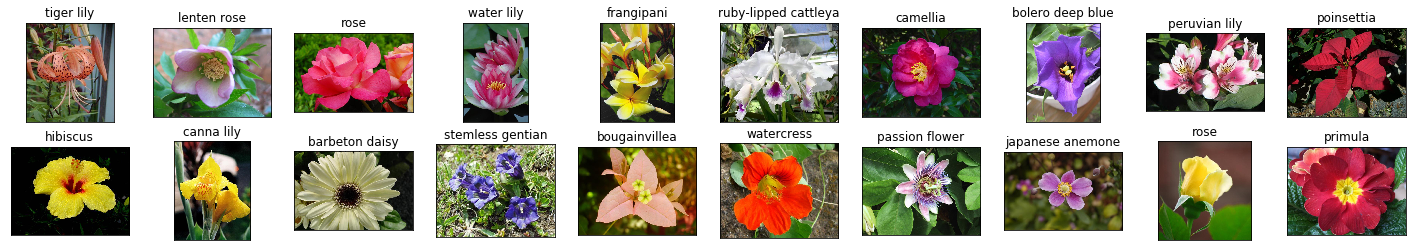

In [12]:
fig=plt.figure(figsize=(25,4))
for i in range(20):
    images,labels=next(iter(trainloader))
    images=images.numpy()
    
    ax=fig.add_subplot(2,20/2,i+1,xticks=[],yticks=[])
    imshow(images)
    ax.set_title(cat_to_name[labels_classes[labels.item()]])

So safe to initially resize to 500,500 , resize further to 255,255 then centercrop at 224,224

In [13]:
transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.Resize((500,500)),
                                transforms.Resize((255,255)),
                               transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406),
                                                   (0.229, 0.224, 0.225))])
test_transform=transforms.Compose([transforms.Resize((500,500)),
                                transforms.Resize((255,255)),
                               transforms.CenterCrop((224,224)),
                                transforms.ToTensor()])

traindataset=datasets.ImageFolder(root='../data/flower_data/train',transform=transform)
validdataset=datasets.ImageFolder('../data/flower_data/valid',transform=test_transform)

trainloader=torch.utils.data.DataLoader(traindataset,batch_size=32,shuffle=True)
validloader=torch.utils.data.DataLoader(validdataset,batch_size=32,shuffle=True)

In [14]:
diter=iter(trainloader)
images,labels=next(diter)

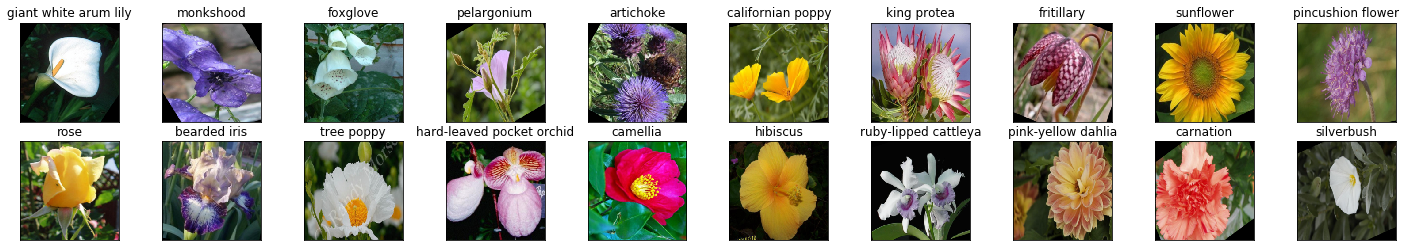

In [15]:
def imshow(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)

images,labels=next(iter(trainloader))
# images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in range(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    imshow(images[idx])
    ax.set_title(cat_to_name[labels_classes[labels[idx].item()]]);

In [16]:
model = models.densenet121(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [17]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [18]:
for param in model.parameters():
    param.requires_grad=False

In [19]:
from collections import OrderedDict

classifier=nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [20]:
model.classifier=classifier

In [21]:
criterion = nn.NLLLoss()
optimizer=torch.optim.Adam(model.classifier.parameters())

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
model.to(device);
def train(Model,trainloader,testloader,criterion,optimizer,epochs=5):
    test_losses,train_losses,test_loss_min=[],[],np.Inf
    for e in range(epochs):
        running_loss=0;

        Model.train();
        for images,labels in trainloader:
#             images_t = images.view(images.shape[0],-1);
            optimizer.zero_grad();
            images,labels=images.to(device),labels.to(device)
            
            logits=Model.forward(images);
            loss_t=criterion(logits,labels);
            loss_t.backward();
            optimizer.step();

            running_loss+=loss_t;

        else:
            test_loss,accuracy=validation(Model,testloader,criterion);

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy))
        if test_loss < test_loss_min:
            torch.save(Model.state_dict(),"model_flower.pt")
            test_loss_min=test_loss
        
        test_losses.append(test_loss/len(testloader))
        train_losses.append(running_loss/len(trainloader))

    return train_losses,test_losses,accuracy

def validation(Model,testloader,criterion):
    test_loss=0;
    accuracy=0;

    Model.eval();
    images_num=0;
    with torch.no_grad():
        for images,labels in testloader:
            images_num+=images.shape[0];
#             images_t=images.view(images.shape[0],-1);
            images,labels=images.to(device),labels.to(device)
            logits=Model.forward(images);
            loss_t=criterion(logits,labels)
            test_loss+=loss_t;

            _,pred_labels=torch.topk(logits,1,dim=1)
            equality=(labels==pred_labels.view(*labels.shape))

            accuracy += torch.sum(equality)

    overall_acc=accuracy.float()/images_num;
    return test_loss,overall_acc


In [25]:
# train_loss,test_loss,accuracy=train(model,trainloader,validloader,criterion,
#                                       optimizer,1)

In [ ]:
model.to(device)
epochs=1
steps=0
print_every=10
running_loss=0
for e in range(epochs):
    for images,labels in trainloader:
        steps+=1;
        images,labels=images.to(device),labels.to(device)
        outputs=model.forward(images);
        optimizer.zero_grad()
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss;

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()